<H1> The West Nile Virus </H1>
Source: https://www.kaggle.com/c/predict-west-nile-virus

---

<H2><span style="color:brown">Overview</span></H2>

The West Nile Virus is mostly spread to humans through infected mosquitos and roughly 20% of people who become infected with the virus develop symptoms ranging from a persistent fever to serious neurological illness that can result in death.

In 2002, the first human cases of the West Nile Virus were reported in Chicago. By 2004, the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

<H2><span style="color:brown">Objective</span></H2>

In order to be successful in this project, we must achieve the following:
<ul>
    <li>Conduct exploratory analysis and determine what factors are affecting the presence of the West Nile Virus in mosquitos</li>
    <li>Build a logistic regression model with an AUC score of over 50%</li>
    <li>Identify what threshold is required for this logistic model to identify actual cases of the virus at a 100% rate</li>
</ul>

The goal is to create an improved detection model that will ultimately save many lives in the city of Chicago.

<H2><span style="color:brown">Data</span></H2>

<ul>
    <li>Main data - Training set in 2007, 2009, 2011, 2013 (train.csv)</li>
    <li>Weather data from 2007 to 2014 (weather.csv)</li>
</ul>

<H2><span style="color:blue">Exploratory Data Analysis</span></H2>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from haversine import haversine, Unit

train = pd.read_csv('train.csv', na_values=['M']) # replace all 'M' values to null
weather = pd.read_csv('weather.csv', na_values=['M','-']) # replace all 'M' and '-' values to null

In [55]:
weather = weather.replace('  T', 0.005) # replace all trace values to 0.005 to indicate minimal 
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])

# estimating missing values for the weather data by using forward fill
weather['Tavg'] = weather['Tavg'].fillna(method='ffill')
weather['WetBulb'] = weather['WetBulb'].fillna(method='ffill')
weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method='ffill')

print(train.info())
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  month                   10506 non-null  int64 

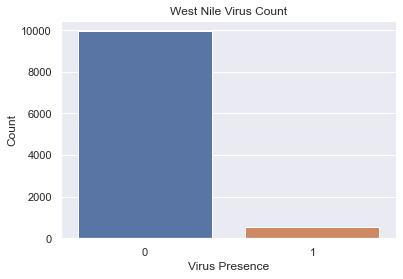

Wnv0 count:  9955
Wnv1 count:  551


In [3]:
sns.set()

train['WnvPresent'].value_counts()

sns.countplot(x='WnvPresent', data=train)
plt.title('West Nile Virus Count')
plt.xlabel('Virus Presence')
plt.ylabel('Count')
plt.show()

print("Wnv0 count: ", len(train[train['WnvPresent'] == 0]))
print("Wnv1 count: ", len(train[train['WnvPresent'] == 1]))

We have an imbalanced dataset with the ratio of the non-presence to the presence of the West Nile Virus at 95:5.

Species
CULEX PIPIENS/RESTUANS    66268
CULEX PIPIENS             44671
CULEX RESTUANS            23431
CULEX TERRITANS             510
CULEX SALINARIUS            145
CULEX ERRATICUS               7
CULEX TARSALIS                7
Name: NumMosquitos, dtype: int64



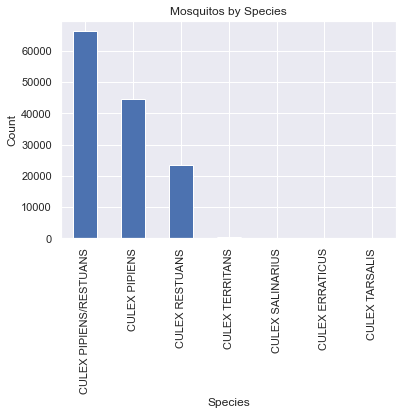

In [4]:
mosquitos_by_species = train.groupby('Species')['NumMosquitos'].sum()

print(mosquitos_by_species.sort_values(ascending=False))

print()

mosquitos_by_species.sort_values(ascending=False).plot(kind='bar')
plt.title('Mosquitos by Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

Over 99.5% of the mosquito species are either Culex Pipiens, Culex Restuans, or Culex Pipiens/Restuans.
These are the most common types of mosquitos in the Chicago area.

Species
CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
CULEX ERRATICUS             0
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: WnvPresent, dtype: int64



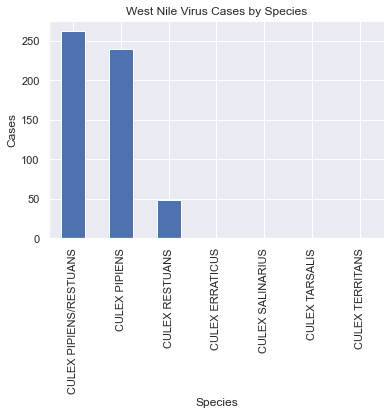

In [5]:
wnv1_by_species = train.groupby('Species')['WnvPresent'].sum()

print(wnv1_by_species.sort_values(ascending=False))

print()

wnv1_by_species.sort_values(ascending=False).plot(kind='bar')
plt.title('West Nile Virus Cases by Species')
plt.xlabel('Species')
plt.ylabel('Cases')
plt.show()

The Culex Pipiens, Culex Restuans, and Culex Pipiens/Restuans are the only species that carried the West Nile Virus based on our data.

In [6]:
print((wnv1_by_species/mosquitos_by_species).sort_values(ascending=False))

Species
CULEX PIPIENS             0.005373
CULEX PIPIENS/RESTUANS    0.003954
CULEX RESTUANS            0.002091
CULEX ERRATICUS           0.000000
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
dtype: float64


The chances that these 3 species carry the West Nile Virus is approximately 0.2-0.5%. The Culex Pipiens species are the most likely to carriers of the virus.

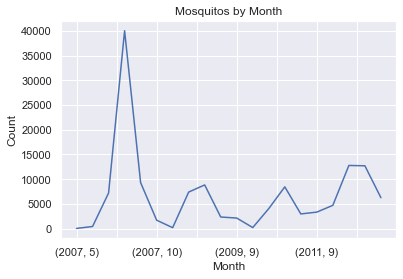

In [7]:
train['Date'] = pd.to_datetime(train['Date'])

train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year

mosquitos_by_month = train.groupby(['year', 'month'])['NumMosquitos'].sum()

mosquitos_by_month.plot()
plt.title('Mosquitos by Month')
plt.ylabel('Count')
plt.xlabel('Month')
plt.show()

There was an abnormal number of mosquitos recorded in Aug 2007 at 40,015. Our data shows that there are sharp increases in mosquitos during the Summer season. The number of mosquitos peak in the month of July or August of every year.


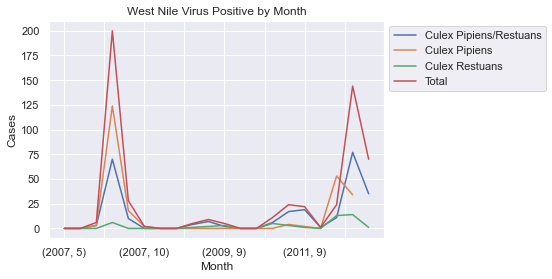

In [8]:
wnv1_by_month = train.groupby(['year', 'month'])['WnvPresent'].sum()
pipiens_restuans_wnv1_by_month = train[train['Species'] == 'CULEX PIPIENS/RESTUANS'].groupby(['year', 'month'])['WnvPresent'].sum()
pipiens_wnv1_by_month = train[train['Species'] == 'CULEX PIPIENS'].groupby(['year', 'month'])['WnvPresent'].sum()
restuans_wnv1_by_month = train[train['Species'] == 'CULEX RESTUANS'].groupby(['year', 'month'])['WnvPresent'].sum()

pipiens_restuans_wnv1_by_month.plot(label='Culex Pipiens/Restuans')
pipiens_wnv1_by_month.plot(label='Culex Pipiens')
restuans_wnv1_by_month.plot(label='Culex Restuans')
wnv1_by_month.plot(label='Total')

plt.title('West Nile Virus Positive by Month')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.65))
plt.show()

The highest cases of the West Nile Virus is in August of every year. Because of the unusually high number of mosquitos recorded in August of 2007, there was also a spike in the West Nile Virus during that month. The cases were low for the next several years in comparison until it spiked up again in August of 2013.

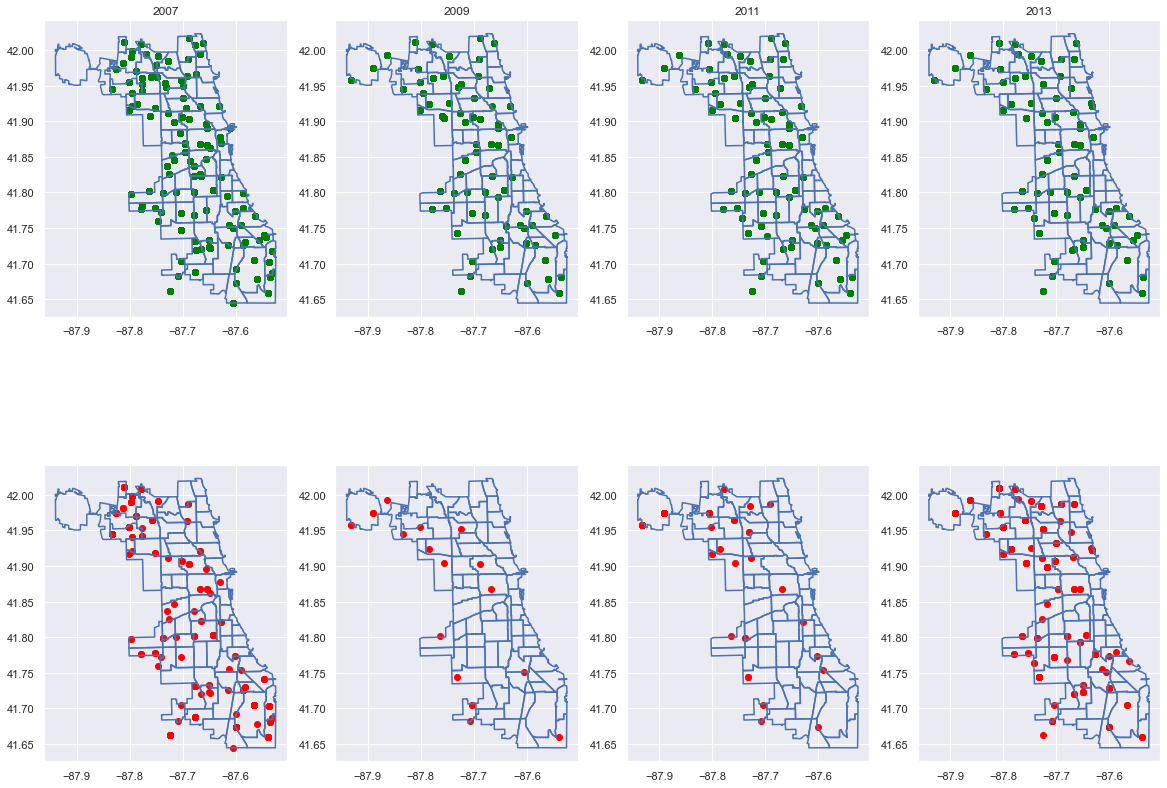

In [9]:
# using Geopandas to visually plot cases
geometry = [Point(xy) for xy in zip(train['Longitude'], train['Latitude'])]

chicago = gpd.read_file('geo_export_b5b9ef20-61c6-4fa2-bd3b-61ef37e3eaa8.shp')
geo_df = gpd.GeoDataFrame(data=train, geometry=geometry)

chicago.crs = 'epsg:4326'
geo_df.crs = 'epsg:4326'

fig, ax = plt.subplots(2,4, figsize=(20,15))

# plot when WNV is not present
chicago.boundary.plot(ax=ax[0,0])
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2007)].plot(color='green', ax=ax[0,0])
ax[0,0].set_title('2007')

chicago.boundary.plot(ax=ax[0,1])
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2009)].plot(color='green', ax=ax[0,1])
ax[0,1].set_title('2009')

chicago.boundary.plot(ax=ax[0,2])
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2011)].plot(color='green', ax=ax[0,2])
ax[0,2].set_title('2011')

chicago.boundary.plot(ax=ax[0,3])
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2013)].plot(color='green', ax=ax[0,3])
ax[0,3].set_title('2013')

# plot when WNV is present
chicago.boundary.plot(ax=ax[1,0])
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2007)].plot(color='red', ax=ax[1,0])

chicago.boundary.plot(ax=ax[1,1])
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2009)].plot(color='red', ax=ax[1,1])

chicago.boundary.plot(ax=ax[1,2])
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2011)].plot(color='red', ax=ax[1,2])

chicago.boundary.plot(ax=ax[1,3])
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2013)].plot(color='red', ax=ax[1,3])

plt.show()

A noticeable decrease in the West Nile Virus occurred in 2009 and 2011. The middle part of Chicago seems to have much less cases of the virus during these years. 

In [10]:
# creating 6 regions based on coordinates: Northwest, Northeast, Midwest, Mideast, Southwest, Southeast
conditions = [
    (train['Latitude'] >= 41.90) & (train['Longitude'] <= -87.75),
    (train['Latitude'] >= 41.90) & (train['Longitude'] > -87.75),
    (train['Latitude'] >= 41.75) & (train['Latitude'] < 41.90) & (train['Longitude'] <= -87.69), 
    (train['Latitude'] >= 41.75) & (train['Latitude'] < 41.90) & (train['Longitude'] > -87.69),
    (train['Latitude'] < 41.75) & (train['Longitude'] <= -87.61),
    (train['Latitude'] < 41.75) & (train['Longitude'] > -87.61)
    ]

values = ['Northwest', 'Northeast',  'Midwest', 'Mideast', 'Southwest', 'Southeast']

train['region'] = np.select(conditions, values)

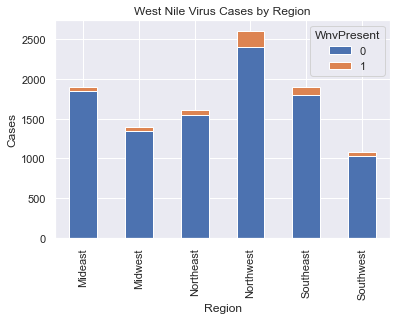

In [60]:
pd.crosstab(train['region'], train['WnvPresent']).plot(kind='bar', stacked=True)

plt.title('West Nile Virus Cases by Region')
plt.xlabel('Region')
plt.ylabel('Cases')
plt.show()

The Northwestern region of Chicago has the most tests and the highest cases of the virus. There were more tests conducted in Mid Chicago than the South but more virus carriers have been found in the South. The Middle part of Chicago is less likely to see the presence of the West Nile Virus.

In [12]:
# Haversine Distance - Using closest weather station to coordinates in train data as "real" weather data
station1_coords = (41.995, -87.933)
station2_coords = (41.786, -87.752)

train['LatLong'] = list(zip(train['Latitude'], train['Longitude']))

weather['Date'] = pd.to_datetime(weather['Date'])
weather_stn1 = weather[weather['Station'] == 1]
weather_stn2 = weather[weather['Station'] == 2]
weather_joined_stn = weather_stn1.merge(weather_stn2, on='Date', suffixes=('_1', '_2'))

train_weather = train.merge(weather_joined_stn, on='Date')

station1_distance = []

for i in train_weather['LatLong']:
    miles = haversine(station1_coords, i, unit=Unit.MILES)
    station1_distance.append(miles)

station2_distance = []

for i in train_weather['LatLong']:
    miles = haversine(station2_coords, i, unit=Unit.MILES)
    station2_distance.append(miles)

train_weather['Distances1'] = station1_distance
train_weather['Distances2'] = station2_distance

train_weather['Diff'] = train_weather['Distances1'] - train_weather['Distances2']

train_weather['Close'] = np.where(train_weather['Diff'] <= 0, 1, 2) 

train_weather['real_tmin'] = np.where(train_weather['Close'] == 1 , train_weather['Tmin_1'], train_weather['Tmin_2'])
train_weather['real_tavg'] = np.where(train_weather['Close'] == 1 , train_weather['Tavg_1'], train_weather['Tavg_2'])
train_weather['real_tmax'] = np.where(train_weather['Close'] == 1 , train_weather['Tmax_1'], train_weather['Tmax_2'])
train_weather['real_codesum'] = np.where(train_weather['Close'] == 1 , train_weather['CodeSum_1'], train_weather['CodeSum_2'])
train_weather['real_preciptotal'] = np.where(train_weather['Close'] == 1 , train_weather['PrecipTotal_1'], train_weather['PrecipTotal_2'])
train_weather['real_dewpoint'] = np.where(train_weather['Close'] == 1 , train_weather['DewPoint_1'], train_weather['DewPoint_2'])
train_weather['real_wetbulb'] = np.where(train_weather['Close'] == 1 , train_weather['WetBulb_1'], train_weather['WetBulb_2'])

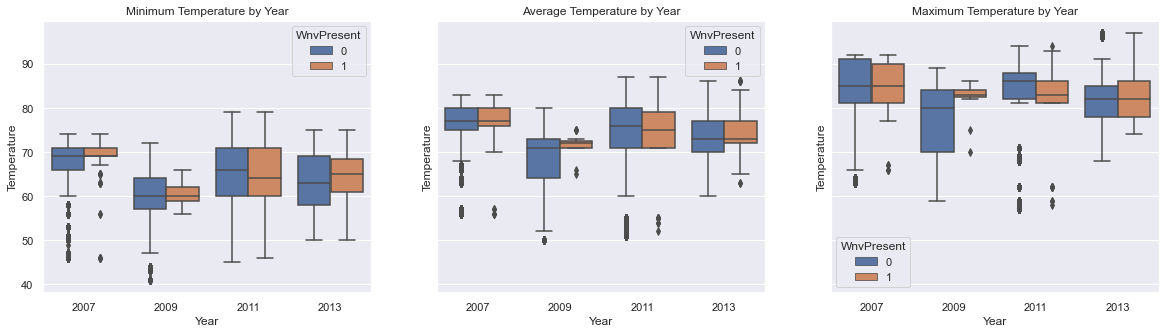

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.boxplot(x=train_weather['year'], y=train_weather['real_tmin'], hue=train_weather['WnvPresent'], ax=ax[0])
ax[0].set_title('Minimum Temperature by Year')
ax[0].set_ylabel('Temperature')
ax[0].set_xlabel('Year')

sns.boxplot(x=train_weather['year'], y=train_weather['real_tavg'], hue=train_weather['WnvPresent'], ax=ax[1])
ax[1].set_title('Average Temperature by Year')
ax[1].set_ylabel('Temperature')
ax[1].set_xlabel('Year')

sns.boxplot(x=train_weather['year'], y=train_weather['real_tmax'], hue=train_weather['WnvPresent'], ax=ax[2])
ax[2].set_title('Maximum Temperature by Year')
ax[2].set_ylabel('Temperature')
ax[2].set_xlabel('Year')

plt.show()

The range of temperatures in 2009 and 2011 when the West Nile Virus is present is smaller than when the virus is not present. Because there were less cases during those years, there were less chances for the range to be larger. 

In 2009, there is a big difference as temperature was roughly between 70-73 degrees when the virus was detected. In comparison, the average temperature range when the virus was not present during that year was between 52-80 degrees.

The average temperature during 2007 and 2013 doesn't seem to play a factor with the presence of the virus.

FG BR HZ                 3.106171
TS TSRA RA FG BR HZ      2.871532
TSRA RA BR               2.861125
TS BR                    1.949739
BR HZ                    1.848425
BR                       1.416275
TS TSRA RA BR            0.566799
TSRA RA DZ BR HZ         0.470582
RA                       0.363011
TSRA RA                  0.171923
TS                       0.071780
TSRA BR HZ              -0.178766
                        -0.196380
TSRA HZ                 -0.247202
HZ                      -0.426440
VCTS                    -0.559338
RA BR HZ                -0.644347
RA BR                   -0.709635
TS TSRA RA BR HZ VCTS   -0.765362
TSRA BR                 -0.789917
RA DZ BR                -0.854297
DZ BR                         NaN
TS TSRA BR                    NaN
TS TSRA BR HZ                 NaN
TS TSRA RA VCTS               NaN
TSRA                          NaN
TSRA BR HZ VCTS               NaN
TSRA RA BR VCTS               NaN
Name: real_codesum, dtype: float64



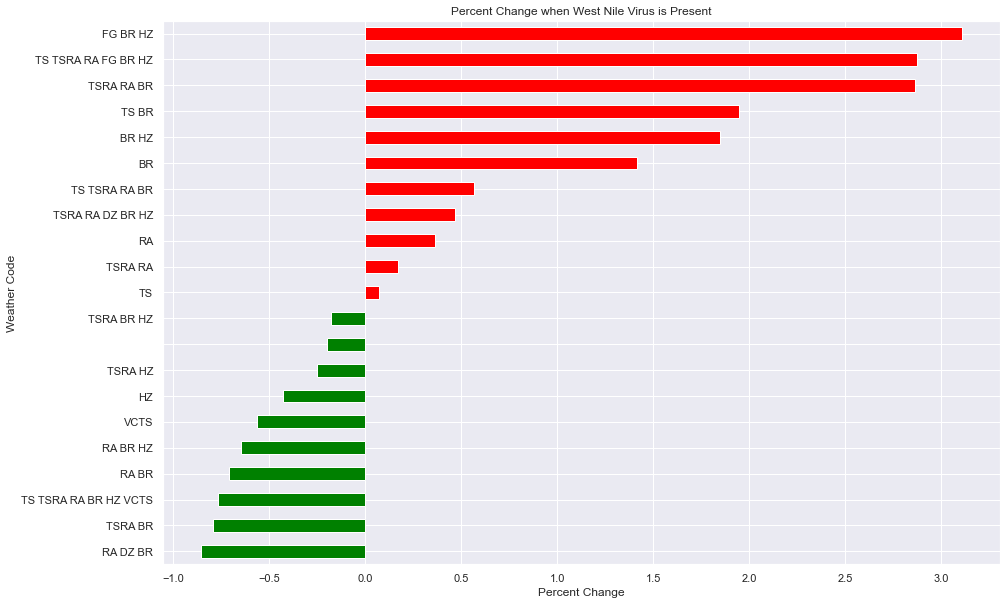

In [14]:
train_weather_wnv1 = train_weather[train_weather['WnvPresent'] == 1]
train_weather_wnv0 = train_weather[train_weather['WnvPresent'] == 0]

codesum_wnv0_pct = train_weather_wnv0['real_codesum'].value_counts(normalize=True).sort_index()
codesum_wnv1_pct = train_weather_wnv1['real_codesum'].value_counts(normalize=True).sort_index()

codesum_pct_change = (codesum_wnv1_pct - codesum_wnv0_pct)/codesum_wnv0_pct
print(codesum_pct_change.sort_values(ascending=False))

print()

fig, ax = plt.subplots(figsize=(15,10))

codesum_pct_change.sort_values().dropna().plot(kind='barh', color=np.where(codesum_pct_change.sort_values() > 0, 'red', 'green'))
ax.set_title('Percent Change when West Nile Virus is Present')
plt.ylabel('Weather Code')
plt.xlabel('Percent Change')
plt.show()

The top 3 weather code combinations with the highest percentage increase when West Nile Virus is present:
<ul>
    <li>Fog, Mist, Haze - 310.62% increase</li>
    <li>Thunderstorm, Thunderstorm/Rain, Rain, Fog, Mist, Haze - 287.15% increase</li>
    <li>Thunderstorm/Rain, Rain, Mist - 286.11% increase</li>
</ul>

In [15]:
other_var = train_weather[['WnvPresent', 'NumMosquitos', 'real_tavg', 'real_preciptotal', 'real_dewpoint', 'real_wetbulb']]

other_var.groupby('WnvPresent').mean()

,NumMosquitos,real_tavg,real_preciptotal,real_dewpoint,real_wetbulb
WnvPresent,,,,,
0,12.106479,73.081768,0.135681,59.497338,64.770568
1,26.350272,75.098004,0.168230,62.482759,67.123412


In [16]:
# percent change when virus is present
other_var.groupby('WnvPresent').mean().pct_change()

,NumMosquitos,real_tavg,real_preciptotal,real_dewpoint,real_wetbulb
WnvPresent,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,1.176543,0.027589,0.239897,0.050177,0.036326


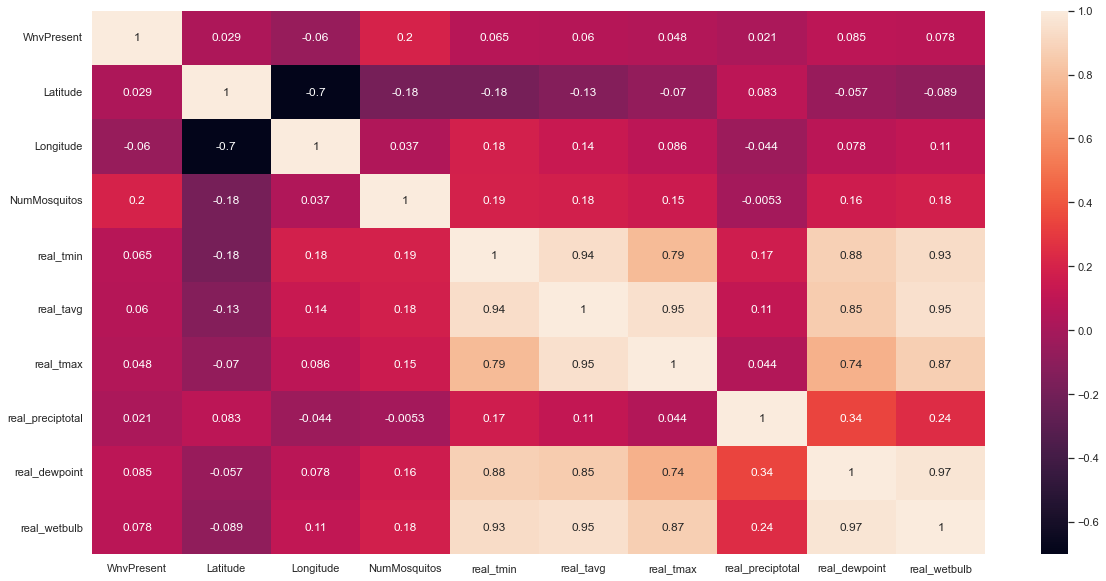

In [17]:
correlation_data = train_weather[['WnvPresent', 'Latitude', 'Longitude', 'NumMosquitos', 'real_tmin', 'real_tavg', 'real_tmax', 'real_preciptotal', 'real_dewpoint', 'real_wetbulb']]

fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(correlation_data.corr(), annot=True)
plt.show()

There are no strong correlations with the virus being present and other variables. 

As expected, temperature and humidity variables are highly correlated.

<H2><span style="color:blue">Logistic Regression</span></H2>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import shap

In [19]:
# only bringing in features that we will use for Logistic Regression Analysis
new_train_weather = train_weather[['WnvPresent', 'year', 'month', 'NumMosquitos', 'Species', 'region', 'real_tmin', 'real_tavg', 'real_tmax', 'real_codesum', 'real_preciptotal', 'real_dewpoint', 'real_wetbulb']]

print(new_train_weather.shape)

new_train_weather.head(5)

(10506, 13)


,WnvPresent,year,month,NumMosquitos,Species,region,real_tmin,real_tavg,real_tmax,real_codesum,real_preciptotal,real_dewpoint,real_wetbulb
0,0,2007,5,1,CULEX PIPIENS/RESTUANS,Northwest,60,74.0,88,BR HZ,0.0,58,65.0
1,0,2007,5,1,CULEX RESTUANS,Northwest,60,74.0,88,BR HZ,0.0,58,65.0
2,0,2007,5,1,CULEX RESTUANS,Northwest,60,74.0,88,BR HZ,0.0,58,65.0
3,0,2007,5,1,CULEX PIPIENS/RESTUANS,Northwest,60,74.0,88,BR HZ,0.0,58,65.0
4,0,2007,5,4,CULEX RESTUANS,Northwest,60,74.0,88,BR HZ,0.0,58,65.0


In [20]:
# creating dummy variables for categorical features
new_train_weather = pd.get_dummies(new_train_weather, columns = ['year', 'month', 'Species', 'region', 'real_codesum'])

print(new_train_weather.shape)

new_train_weather.head(5)

(10506, 59)


,WnvPresent,NumMosquitos,real_tmin,real_tavg,real_tmax,real_preciptotal,real_dewpoint,real_wetbulb,year_2007,year_2009,...,real_codesum_TSRA,real_codesum_TSRA BR,real_codesum_TSRA BR HZ,real_codesum_TSRA BR HZ VCTS,real_codesum_TSRA HZ,real_codesum_TSRA RA,real_codesum_TSRA RA BR,real_codesum_TSRA RA BR VCTS,real_codesum_TSRA RA DZ BR HZ,real_codesum_VCTS
0,0,1,60,74.0,88,0.0,58,65.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,60,74.0,88,0.0,58,65.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,60,74.0,88,0.0,58,65.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,60,74.0,88,0.0,58,65.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,60,74.0,88,0.0,58,65.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# splitting data to independent and dependent variables
x = new_train_weather.drop('WnvPresent', axis=1).values
y = new_train_weather['WnvPresent'].values

In [22]:
dt = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=10)
dt.fit(x, y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

In [23]:
# running Feature Importance
fi_col = []
fi = []

for i, column in enumerate(new_train_weather.drop('WnvPresent', axis=1)):
    print('The feature importance for {} is: {}'.format(column, dt.feature_importances_[i]))

    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for NumMosquitos is: 0.4078222212879186
The feature importance for real_tmin is: 0.02862413350625423
The feature importance for real_tavg is: 0.013207893729735113
The feature importance for real_tmax is: 0.06155540936112132
The feature importance for real_preciptotal is: 0.02609887944635395
The feature importance for real_dewpoint is: 0.0377274770409033
The feature importance for real_wetbulb is: 0.015674317262472537
The feature importance for year_2007 is: 0.0
The feature importance for year_2009 is: 0.002184729119988531
The feature importance for year_2011 is: 0.010160452573462672
The feature importance for year_2013 is: 0.02658951917459052
The feature importance for month_5 is: 0.0
The feature importance for month_6 is: 0.0016908714930963231
The feature importance for month_7 is: 0.012650496540134155
The feature importance for month_8 is: 0.09844718390576056
The feature importance for month_9 is: 0.06768345242666673
The feature importance for month_10 is: 0.0


Feature Importance has been ran to see which features are useful in predicting the presence of the West Nile Virus. We can see that some features have no effect on the presence of the virus and we will remove them from our analysis.

In [47]:
# only keeping the features that have a feature_importance > 0
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns=['feature','feature_importance'])

fi_df = fi_df.sort_values('feature_importance', ascending=False).reset_index()
print(fi_df)

columns_to_keep = fi_df['feature'][0:34]

    index                             feature  feature_importance
0       0                        NumMosquitos            0.407822
1      14                             month_8            0.098447
2      15                             month_9            0.067683
3       3                           real_tmax            0.061555
4       5                       real_dewpoint            0.037727
5      19      Species_CULEX PIPIENS/RESTUANS            0.032375
6      27                    region_Northwest            0.032078
7       1                           real_tmin            0.028624
8      10                           year_2013            0.026590
9       4                    real_preciptotal            0.026099
10     29                    region_Southwest            0.021498
11     18               Species_CULEX PIPIENS            0.020009
12     26                    region_Northeast            0.018821
13      6                        real_wetbulb            0.015674
14     30 

In [25]:
# new independent variables that are relevant to prediction
x = new_train_weather[columns_to_keep].values
y = new_train_weather['WnvPresent'].values

print(x.shape)
print(y.shape)

(10506, 34)
(10506,)


In [26]:
# split data to 2 subsets: training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [27]:
# standardize scale of each variable so that the mean of each column equals to 0
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [28]:
# train model
import warnings
warnings.filterwarnings("ignore")

model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [29]:
confusion_matrix(y_test, y_pred)

array([[1993,    6],
       [  96,    7]], dtype=int64)

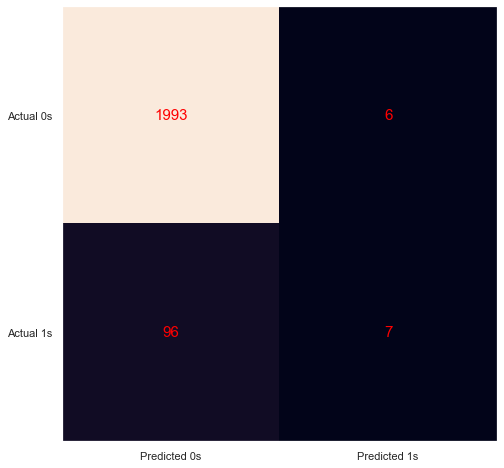

In [30]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j], ha='center', va='center', color='red', fontsize=15)

plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1999
           1       0.54      0.07      0.12       103

    accuracy                           0.95      2102
   macro avg       0.75      0.53      0.55      2102
weighted avg       0.93      0.95      0.93      2102



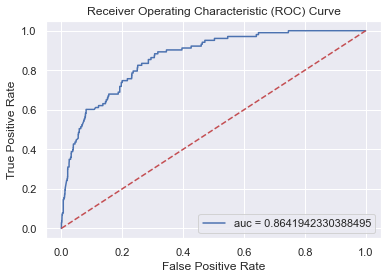

In [32]:
y_pred_proba = model.predict_proba(x_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label='auc = ' + str(auc))
plt.plot([0,1], [0,1], 'r--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.show()

Our data is highly imbalanced which results in the overall accuracy score being high at 95% with a large amount of false negatives. This makes this current model unusable. For a total of 103 virus occurrences in the x_test data, the model only predicted 7% correctly. If we follow this model and spray accordingly, we will have missed 93% of the actual virus cases.

The ROC curve is the most commonly used way to visualize the performance of a binary classifier (classifier with 2 possible output). If a model is perfectly able to classify the true positives from the false positives, it would have an AUC (area under the curve) score of 1. If the model is at 0.5, it is at a point of random guessing because the true positive rate and false positive rate would be equal. We will focus on improving the AUC score to create the best model we can. 

We will also look at recall (fraction of positive predictions out of all the positive instances) for 1 and see what threshold will allow us to confidently predict all positive cases of the virus. Although our model may drop in precision for 1 and overall accuracy, it is more important that our model can correctly predict the presence of the virus rather than correctly predict the non-presence of the virus.

In [33]:
#utilizing undersampling to balance the data
x_rus, y_rus = RandomUnderSampler(sampling_strategy=0.58, random_state=0).fit_resample(x_train, y_train)
print(Counter(y_rus))

model2 = LogisticRegression(random_state=0)
model2.fit(x_rus, y_rus)

y_rus_pred = model2.predict(x_test)

Counter({0: 772, 1: 448})


In [34]:
confusion_matrix(y_test, y_rus_pred)

array([[1694,  305],
       [  33,   70]], dtype=int64)

In [35]:
print(classification_report(y_test, y_rus_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1999
           1       0.19      0.68      0.29       103

    accuracy                           0.84      2102
   macro avg       0.58      0.76      0.60      2102
weighted avg       0.94      0.84      0.88      2102



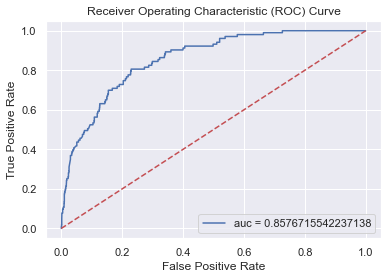

In [36]:
y_rus_predproba = model2.predict_proba(x_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_rus_predproba)
auc = metrics.roc_auc_score(y_test, y_rus_predproba)

plt.plot(fpr, tpr, label='auc = ' + str(auc))
plt.plot([0,1], [0,1], 'r--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.show()

After balancing the data closer to 6:4 through random undersampling, we can see that the confusion matrix does look better and our recall for 1 has drastically improved. This model is becoming more usable but the model still has a recall for 1 of 0.68. In order to eliminate the virus, we need to spray everywhere where a virus is present.

In [37]:
# optimizing the hyperparameters to get the best results using the Grid Search Method
warnings.filterwarnings("ignore")

grid_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.logspace(-4, 4, 20)}

grid_clf = GridSearchCV(model2, 
                        grid_param, 
                        scoring='roc_auc', 
                        n_jobs=-1,
                        cv=5)

grid_clf.fit(x_train, y_train)

# predict values based on new parameters
y_pred_clf = grid_clf.predict(x_test)

print(classification_report(y_test, y_pred_clf))

print("Best hyperparameters: ", grid_clf.best_params_)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1999
           1       0.54      0.07      0.12       103

    accuracy                           0.95      2102
   macro avg       0.75      0.53      0.55      2102
weighted avg       0.93      0.95      0.93      2102

Best hyperparameters:  {'C': 1.623776739188721, 'penalty': 'l2'}


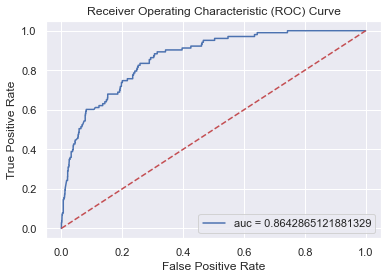

In [38]:
y_pred_clf_proba = grid_clf.predict_proba(x_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_clf_proba)
auc = metrics.roc_auc_score(y_test, y_pred_clf_proba)

plt.plot(fpr, tpr, label='auc = ' + str(auc))
plt.plot([0,1], [0,1], 'r--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.show()

By optimizing the hyperparameters for "penalty" and "C", we were able to increase the AUC from 0.8576 to 0.8642 (approximately 0.76%)

In [39]:
# changing the threshold to find the highest recall value
threshold = 0.04
y_rus_pp = np.where(model2.predict_proba(x_test)[:,1] >= threshold, 1, 0)

confusion_matrix(y_test, y_rus_pp)

array([[ 522, 1477],
       [   0,  103]], dtype=int64)

In [40]:
print(classification_report(y_test, y_rus_pp))

              precision    recall  f1-score   support

           0       1.00      0.26      0.41      1999
           1       0.07      1.00      0.12       103

    accuracy                           0.30      2102
   macro avg       0.53      0.63      0.27      2102
weighted avg       0.95      0.30      0.40      2102



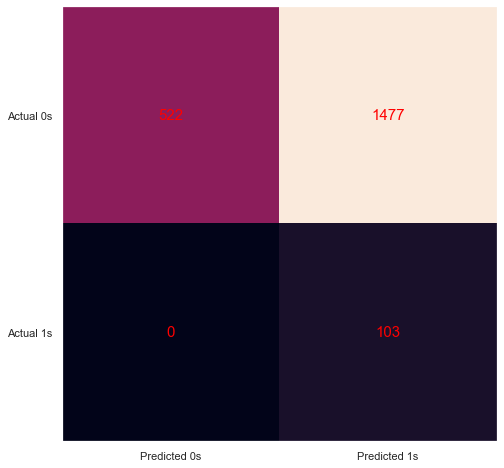

In [41]:
cm2 = confusion_matrix(y_test, y_rus_pp)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm2)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm2[i,j], ha='center', va='center', color='red', fontsize=15)
        
plt.show()

By adjusting the threshold from 0.5 to 0.04, we were able to predict 100% of the actual virus cases. We achieved a perfect recall for 1 at the cost of recall for 0 and precision for 1.

This would be an acceptable model to use in our case. With this model, we will be overspraying areas if we have any doubt at all that a virus may be present. We can be confident that all the areas that are infected will be sprayed and as a result, the spread of the virus will be stopped in the Chicago area.

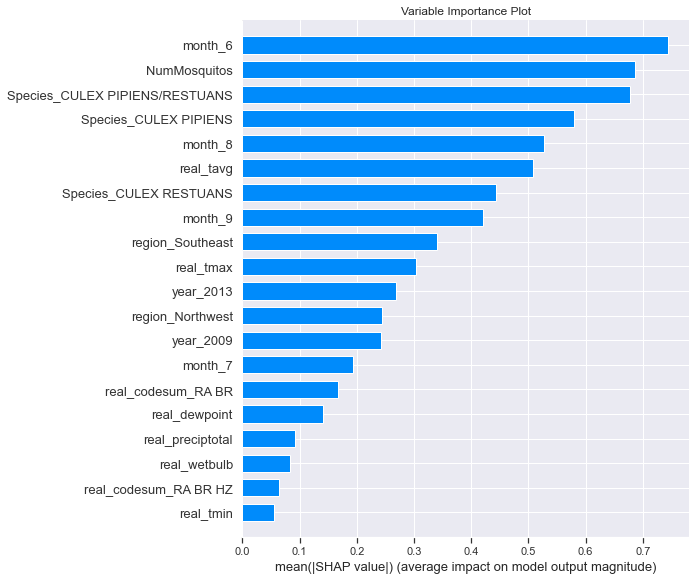

In [51]:
# Using SHAP (SHapley Additive exPlanations) to better understand machine learning model
explainer = shap.Explainer(model2, x_train, feature_names = list(columns_to_keep))
shap_values = explainer(x_train)

plt.title('Variable Importance Plot')
shap.summary_plot(shap_values, x_train, plot_type='bar')

By using SHAP, we created a bar plot of the summary where we are able to see which features were the most impactful on our prediction model, whether it affected it positively or negatively, in descending order. 

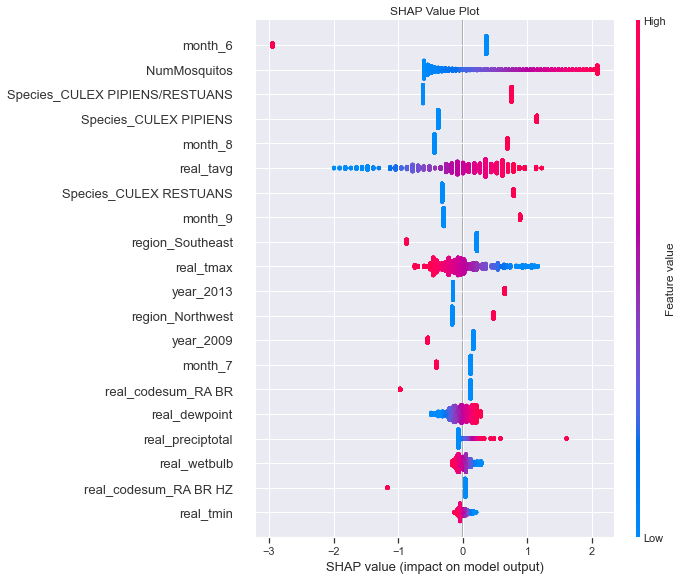

In [62]:
plt.title('SHAP Value Plot')
shap.summary_plot(shap_values, x_train)

The SHAP summary plot above, displays the following information:

<ul>
    <li>Feature importance: Variables are ranked in descending order.</li>
    <li>Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.</li>
    <li>Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.</li>
    <li>Correlation: A high level of the “number of mosquitos” has a high and positive impact on the positive prediction of the virus. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the "month of June (month_6)" is negatively correlated with the target variable.</li>
</ul>

We can see that the "month of June (month_6)" had the highest impact on our prediction model negatively. This means that our model predicted the non-presence of the virus mostly when it was the "month of June".

The following few features, from the "number of mosquitos (NumMosquitos)" to the "month of September (month_9)", were all positively correlated to the prediction of the presence of the virus in descending order. For example, the "number of mosquitos" had the highest impact on the prediction of the presence of the virus followed by the "Culex Pipiens/Restuans species" and the "Culex Pipiens species".  

In [54]:
# print("Intercept is: ", model2.intercept_)

# model2_coef = pd.DataFrame({"Feature":columns_to_keep.tolist(), "Coefficients":model2.coef_[0]})
# model2_coef.sort_values('Coefficients', ascending=False).reset_index()